## Objet du programme :

Le but de ce programme est de réaliser un clustering de type de parcours à partir d'un log d'activité mentionnant :

Un identifiant

Une date associée à l'activité

Un type d'activité

## SECTION PARAMETRAGE

In [1]:
from datetime import datetime

#import pyodbc
import sqlalchemy
#import sqlalchemy as msql
#import Connexion_bdd as Cx_bdd
import numpy as np
import pandas as pd
import Requetes_SQL as Req_SQL
import matplotlib.pyplot as plt
import seaborn as sns
#import dtw as dtw
#import tsfresh #TimeSeries Transformation library
import my_custom_func_TS_Clust_1 as Mcftsc
import my_custom_func_Clustering as McfC
import my_custom_func_Carepath_plotting as Mcfcp
import mlflow

from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree

#SET THE RANDOM SET FOR SKLEARN
#np.random.seed(0)

In [2]:
#Project Classes
#import FSQL_Classes as FSQLC
import Sql_Alchemy_Classes as AlSQL
#import Parcours_Classes as PC

2023-12-18 18:05:35,782 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2023-12-18 18:05:35,783 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-12-18 18:05:35,784 INFO sqlalchemy.engine.Engine SELECT schema_name()
2023-12-18 18:05:35,785 INFO sqlalchemy.engine.Engine [generated in 0.00044s] ()
2023-12-18 18:05:35,787 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2023-12-18 18:05:35,788 INFO sqlalchemy.engine.Engine [generated in 0.00047s] ()
2023-12-18 18:05:35,789 INFO sqlalchemy.engine.Engine SELECT TOP (10) [idUFX_Ress_Equ] FROM [ICO_Activite].[dbo].[Listing_UF_V3]
2023-12-18 18:05:35,789 INFO sqlalchemy.engine.Engine [raw sql] ()
Connexion BDD - OK


In [3]:
#ML FLOW Configuration

#Initialization of MLFlow UI
import subprocess
# Split the command and its arguments into separate elements
command = ['mlflow', 'server', '--host', '127.0.0.1', '--port', '8080']
# Run the shell command in the background
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# LAUNCH ML FLOW UI
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Set an experiment name, which must be unique and case-sensitive.
experiment = mlflow.set_experiment("Clustering parcours_V2")
mlflow.set_experiment_tag("release.version", "0.1")

# Get Experiment Details
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")

# Launch a run into the experiment
mlflow.end_run()
mlflow.start_run()

Experiment_id: 949948631190999289
Artifact Location: mlflow-artifacts:/949948631190999289
Tags: {'release.version': '0.1'}
Lifecycle_stage: active


<ActiveRun: >

## IMPORT DES DONNEES

In [4]:
DSprefix='000_DS_'
Create_dataset_parameters={DSprefix + 'My_NIP_filter_1rst_date': '01-01-2019 00:00:00',
                            DSprefix + 'My_NIP_filter_2nd_date_delta_in_days': 2,
                            DSprefix + 'Site': '2',
                            DSprefix + 'Start_Window_time': '01-09-2018 00:00:00',
                            DSprefix + 'End_Window_time': '12-31-2020 00:00:00',
                            }
myouputpath='../06 - Temp_outputs/'

In [5]:
mlflow.log_params(Create_dataset_parameters)

In [6]:
Caracteristiques_Dataset=Mcftsc.Create_dataset(Create_dataset_parameters,DSprefix)

STEP 1.0 : Delete old Tables
2023-12-18 18:05:39,125 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-18 18:05:39,126 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_Py_A_Actes_Export
2023-12-18 18:05:39,126 INFO sqlalchemy.engine.Engine [generated in 0.00047s] ()
2023-12-18 18:05:39,129 INFO sqlalchemy.engine.Engine COMMIT
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-01-01 00:00:00 - Date2  = 2019-01-03 00:00:00 - launched at 2023-12-18 18:05:39.130672
2023-12-18 18:05:39,130 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-18 18:05:39,131 INFO sqlalchemy.engine.Engine  EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE_AND_DATASET_ON_2_DATES A_Actes_ICO_2018_2021_V2_TRIMED,Tmp_Py_A_Actes_Export,'2019-01-01 00:00:00','2019-01-03 00:00:00','2018-01-09 00:00:00','2020-12-31 00:00:00',2
2023-12-18 18:05:39,131 INFO sqlalchemy.engine.Engine [generated in 0.00056s] ()
2023-12-18 18:05:40,020 INFO sqlalchemy.engine.Engine COMMIT
STEP 1.2 : Prepare_Dat

In [7]:
# Create the DataFrame
df = pd.DataFrame.from_dict(Caracteristiques_Dataset)

# Convert specified columns to dictionary
mydict = df.iloc[:, 6:].to_dict(orient='list')

# Filter dictionary to contain only float values and not lists
for key, value in mydict.items():
    if len(value) == 1 :
        mydict[key] = value[0]

mlflow.log_metrics(mydict)

## AFFICHAGE GENERAL DES DONNEES

In [8]:
#Get all actes in the Dataset

Requete = """
  SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  """
  
Actes_Total=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,True) #FSQLC.F_SQL_Requete(FSQLC.cnxn,Requete,FSQLC.pyodbc,'No')
Actes_Total


2023-12-18 18:05:55,141 INFO sqlalchemy.engine.Engine 
  SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  
2023-12-18 18:05:55,141 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


ID_A         NIP       N_S       DD_A       DF_A       DD_M  \
0       14029260  N201801031  N1638617 2018-03-30 2018-03-30 1899-12-30   
1       14029261  N201801031  N1638617 2018-03-30 2018-03-30 1899-12-30   
2       14029457  N201801031  N1638617 2018-03-29 2018-03-29 1899-12-30   
3       14029458  N201801031  N1638617 2018-03-29 2018-03-29 1899-12-30   
4       14601393  N201805045  N2074530 2020-08-20 2020-08-20 1899-12-30   
...          ...         ...       ...        ...        ...        ...   
172047  15278435  N201806070  N2025689 2020-05-18 2020-05-18 1899-12-30   
172048  15278863  N201306912  N2018657 2020-05-01 2020-05-01 1899-12-30   
172049  15278864  N201306912  N2018657 2020-05-01 2020-05-01 1899-12-30   
172050  15169258  N201807209  N2080275 2020-09-01 2020-09-01 1899-12-30   
172051  15169259  N201807209  N2080275 2020-09-01 2020-09-01 1899-12-30   

             HD_M       DF_M       HF_M   UFX  ... AC_Asso Lc_Prix UFH UFH_L  \
0      1899-12-30 1899-12-30 1899-12-30  1937  ...       0    0.27             
1      1899-12-30 1899-12-30 1899-12-30  1937  ...       0    0.27             
2      1899-12-30 1899-12-30 1899-12-30  1937  ...       0    0.27             
3      1899-12-30 1899-12-30 1899-12-30  1937  ...       0    0.27             
4      1899-12-30 1899-12-30 1899-12-30  9057  ...       0      50             
...           ...        ...        ...   ...  ...     ...     ...  ..   ...   
172047 1899-12-30 1899-12-30 1899-12-30  7172  ...       0    3.15             
172048 1899-12-30 1899-12-30 1899-12-30  9057  ...       0      23             
172049 1899-12-30 1899-12-30 1899-12-30  9057  ...       0       5             
172050 1899-12-30 1899-12-30 1899-12-30  9057  ...       0      23             
172051 1899-12-30 1899-12-30 1899-12-30  9057  ...       0       5             

       Prix_Acte Cout_Acte Statut Code_Equip Site Source  
0                               H               2   NGAP  
1                               H               2   NGAP  
2                               H               2   NGAP  
3                               H               2   NGAP  
4                               E               2   NGAP  
...          ...       ...    ...        ...  ...    ...  
172047                          H               2   NGAP  
172048                          E               2   NGAP  
172049                          E               2   NGAP  
172050                          E               2   NGAP  
172051                          E               2   NGAP  

[172052 rows x 32 columns]

AFFICHAGE DES PARCOURS COMPLETS DES PATIENTS SELECTIONNES

In [9]:
#import importlib
#importlib.reload(Mcftsc)

2023-12-18 18:05:57,574 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP

2023-12-18 18:05:57,575 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


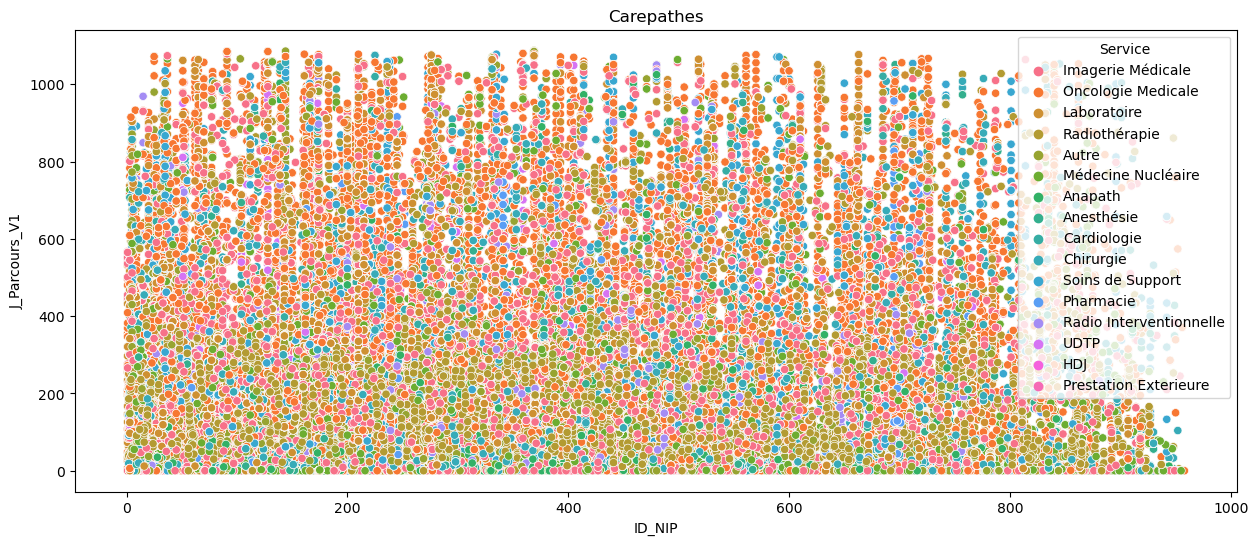

In [10]:
#Recuperer une table acte pour affichage
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP
"""
df_Actes_graph=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

Mcftsc.plot_carepath(df_Actes_graph,myouputpath+ 'Actes_total.png')
mlflow.log_artifact(myouputpath+'Actes_total.png', "DS_General_plot")

AFFICHAGE DES PARCOURS RADIOTHERAPIE DES PATIENTS

2023-12-18 18:06:07,395 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Acte.[Service] = 'Radiothérapie'

2023-12-18 18:06:07,396 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


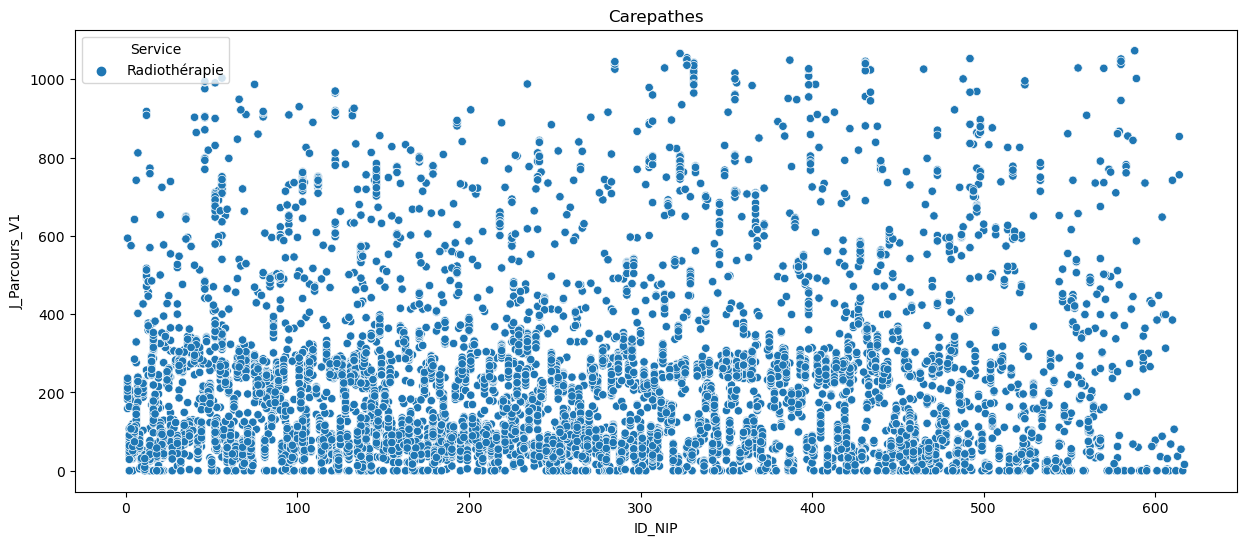

In [11]:
#Recuperer une table acte pour affichage
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Acte.[Service] = 'Radiothérapie'
"""
df_Actes_graph0=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

myoutputfile='Actes_rdth.png'
Mcftsc.plot_carepath(df_Actes_graph0,myouputpath + 'Actes_rdth.png')
mlflow.log_artifact(myouputpath + 'Actes_rdth.png', "DS_General_RDTH_plot")

## PARAMETRES D'AGGREGATION :

### creation d'un dictionnaire pour les multiples requetes d'aggrégation

Aggreg_parameters
    #PARAM1 = CHOICE = 
       	#-- 0 : REPORT DAYLY turnover from stardate of calendar (1 column = 1 DAY), CURSOR LINES ARE DAYS
		#-- 1 : REPORT WEEKLY turnover from stardate of calendar  (1 column = 1 WEEK), CURSOR LINES ARE WEEKS
		#-- 2 : REPORT MONTHLY turnover from stardate of calendar  (1 column = 1 month), CURSOR LINES ARE MONTHS
		#-- 3 : REPORT TRIMESTER turnover for the @YEAR (1 column = 3 months), CURSOR LINES ARE TRIMESTERS
		#-- 4 : REPORT ALL YEAR turnovers (1 column = 1 Year), CURSOR LINES ARE YEARS
    'Report_type': '2',  #--1

    #PARAM2 'TYPE AGGREG' --PARAMETER 3: @AggParameter as nvarchar(20)
		#--CALENDAR : Par date calendaire
		#--PARCOURS : Par date de parcours
    'Aggreg_type': 'PARCOURS',

    #Date ref
    'Date_ref' : "''",

    #0 --PARAMETER 4 : @AggParameter_min as int (NB jours)
    'Start_at_item': '0',

    #50 --PARAMETER 5 : @AggParameter_max as int (NB jours)
    'Stop_at_item': '36', # --104

    #'PRESENCE'	-- PARAMETER 4 : @AggMeth as nvarchar(20) --OK
		#--PRESENCE : -> FUNCTION COUNT
		#--COUNT -> FUNCTION SUM
		#--DENSITE -> Function SUM / Length of aggregation choice (1, 7, 30.41 , 365.25)
    'Method': 'COUNT',

    #'3'	-- PARAMETER 5  @Filter1_type as nvarchar(20
          #--0-ALL
          #--1-SERVICE -> from Listing_UF_V3
          #--2-ACTIVITE -> from Listing_UF_V3
          #--3-PHASE PARCOURS -> from Listing_UF_V3
          #--4-DIMENSION PARCOURS -> from Listing_UF_V3
          #--5-POIDS ACTE -> from Listing_UF_V3
          #--6-TYPE DE SEQUENCE -> from Tmp_Type_Seq
          #--7-TYPE DE PARCOURS-- -> (After Clustering only)
          #--8-R_NGAP
          #--9-R_CCAM
          #--10-Statut
          #--11-UFH
          #--12-INX

    'Type_filter1': '6',
    'Val_filter1': 'TRAIT', #Filter value,
    #'3'	-- PARAMETER 5  @Filter1_type as nvarchar(20)
    'Type_filter2': '1',
    'Val_filter2': 'Radiothérapie', #Filter value

    #J0
      #--V1
      #--V2
      #--V3
      #--V4"""
    'Param_J0':'V3'

In [12]:
Aggprefix='010_Agg_'
Aggreg_parameters={Aggprefix + 'Report_type': '2',
                        Aggprefix + 'Aggreg_type': 'PARCOURS',
                        Aggprefix + 'Date_ref': "''",
                        Aggprefix + 'Start_at_item': '0',
                        Aggprefix + 'Stop_at_item': '12',
                        Aggprefix + 'Method': 'COUNT',
                        Aggprefix + 'Type_filter1': '6',
                        Aggprefix + 'Val_filter1': 'TRAIT',
                        Aggprefix + 'Type_filter2': '1',
                        Aggprefix + 'Val_filter2': 'Radiothérapie',
                        Aggprefix + 'Param_J0': 'V3',
                            }
#Tmp_Carac_Actes
#Tmp_A_Actes_Table_Analyse

Aggreg_parameters_TT_RDTH=Aggreg_parameters.copy()
Aggreg_parameters_TT_RDTH[Aggprefix + 'Val_filter2']= 'Radiothérapie'

Aggreg_parameters_TT_CHIR=Aggreg_parameters.copy()
Aggreg_parameters_TT_CHIR[Aggprefix + 'Val_filter2']= 'Chirurgie'

Aggreg_parameters_TT_CHIMIO=Aggreg_parameters.copy()
Aggreg_parameters_TT_CHIMIO[Aggprefix + 'Val_filter2']= 'Oncologie Medicale'

Aggreg_parameters_TT_UDTP=Aggreg_parameters.copy()
Aggreg_parameters_TT_UDTP[Aggprefix + 'Val_filter2']= 'UDTP'

Aggreg_parameters_TT_MN=Aggreg_parameters.copy()
Aggreg_parameters_TT_MN[Aggprefix + 'Val_filter2']= 'Médecine Nucléaire'

Aggreg_parameters_TT_RI=Aggreg_parameters.copy()
Aggreg_parameters_TT_RI[Aggprefix + 'Val_filter2']= 'Radio Interventionnelle'

Aggreg_parameters_TT_autre=Aggreg_parameters.copy()
Aggreg_parameters_TT_autre[Aggprefix + 'Val_filter2']= 'Autre'


Aggreg_parameters_SUIVI_CT_CS=Aggreg_parameters.copy()
Aggreg_parameters_SUIVI_CT_CS[Aggprefix + 'Val_filter1']= 'SUIVI_CT'
Aggreg_parameters_SUIVI_CT_CS[Aggprefix + 'Type_filter2']= '3'
Aggreg_parameters_SUIVI_CT_CS[Aggprefix + 'Val_filter2']= 'Consultation'

Aggreg_parameters_SUIVI_LT_CS=Aggreg_parameters.copy()
Aggreg_parameters_SUIVI_LT_CS[Aggprefix + 'Val_filter1']= 'SUIVI_LT'
Aggreg_parameters_SUIVI_LT_CS[Aggprefix + 'Type_filter2']= '3'
Aggreg_parameters_SUIVI_LT_CS[Aggprefix + 'Val_filter2']= 'Consultation'

Aggreg_parameters_INIT_NEW_CS=Aggreg_parameters.copy()
Aggreg_parameters_INIT_NEW_CS[Aggprefix + 'Val_filter1']= 'INIT_NEW'
Aggreg_parameters_INIT_NEW_CS[Aggprefix + 'Type_filter2']= '3'
Aggreg_parameters_INIT_NEW_CS[Aggprefix + 'Val_filter2']= 'Consultation'

Aggreg_parameters_INIT_OLD_CS=Aggreg_parameters.copy()
Aggreg_parameters_INIT_OLD_CS[Aggprefix + 'Val_filter1']= 'INIT_OLD'
Aggreg_parameters_INIT_OLD_CS[Aggprefix + 'Type_filter2']= '3'
Aggreg_parameters_INIT_OLD_CS[Aggprefix + 'Val_filter2']= 'Consultation'


In [13]:
#Define and save the aggregation parameters
Parameters_list=[Aggreg_parameters_TT_RDTH]
for param in Parameters_list:
    mlflow.log_params(param)

#Get the aggregation table
Aggreg_Patients=Mcftsc.get_Aggreg_Dataset2(Parameters_list,Aggprefix)

#Save the aggregation table !!!!!!  A DEPLACER A LA FIN DU NOTEBOOK POUR INTEGRER LES RESULTATS DE CLUSTERING
Aggreg_Patients['df'].to_csv(myouputpath + 'Agg_Pat.csv')
mlflow.log_artifact(myouputpath + 'Agg_Pat.csv', "Aggreg_Dataset")

Number of aggregation dimensions: 1
2023-12-18 18:06:08,661 INFO sqlalchemy.engine.Engine EXECUTE [dbo].[ReportCarePathActivtiy_By_actes] 2,'PARCOURS','',0,12,'COUNT',6,'TRAIT',1,'Radiothérapie','V3'
2023-12-18 18:06:08,661 INFO sqlalchemy.engine.Engine [raw sql] ()


AlSQL_Requete - OK


## BOUCLE D'AGGREGATION

### AGGREGATION UNITAIRE

In [14]:
#AJOUTER ICI SI BESOIN UNE FONCTION DE POSTRAITEMENT DU DATASET AGGREG (F.Ex : MOBILE AVERAGE)

# 0- Courbe en l'état, présence au cours de l'aggrégat temporel.
# A developper ?
# 1- CUMUL DU NB DE SEJOURS DE TT RDTH, CHIR OU CHIMIO au cours du temps
# 2- Moyenne mobile sur (x mois/semaine) du nb de sejour de tt de RDTH, CHIR OU CHIMIO


#PREPARER AU PASSAGE EN :

#- FONCTION DE CLUSTERING DE PARCOURS
    #INPUTS : 
        
        #CLUSTER 1 (TIME WINDOW)
            # TABLE DE CLUSTERING (Dist_matrix)
            # METHODE DE CLUSTERING (KMEANS, HIERARCHICAL, GMM) (Cluster 1 on Time Window)
            # NOM DE LA DIMENSION DE CLUSTERING (Cluster 1 on Time Window)
            # NB OF FORCED CLUSTERS OR OPTIMAL COMPUTED ?  (Cluster 1 on Time Window)
        #CLUSTER 2 (PARCOURS DIMENSION)
            # TABLE DE CLUSTERING (Dist_matrix) avec les lignes correspondant aux index des identifiants du DF 'Aggreg'
            # METHODE DE CLUSTERING (KMEANS, HIERARCHICAL, GMM)
            # NOM DE LA DIMENSION DE CLUSTERING 
            # NB OF FORCED CLUSTERS OR OPTIMAL COMPUTED ? 

    #OUTPUTS:
        #CLUSTER 1 (TIME WINDOW)
            # OPTIMAL NB OF CLUSTER (Cluster 1 on Time Window)
            # PLOT OF OPTIMAL NB OF CLUSTER (ELBOW CURVE)   (Cluster 1 on Time Window)
            # DATAFRAME TO BE MERGE TO THE AGGREG

        #CLUSTER 2 (PARCOURS DIMENSION)
            # OPTIMAL NB OF CLUSTER (Cluster 1 on Time Window)
            # PLOT OF OPTIMAL NB OF CLUSTER (ELBOW CURVE)   (Cluster 1 on Time Window)
            # DATAFRAME TO BE MERGE TO THE AGGREG
            # GET THE MEAN INDIVIDUAL
            # SUMMARY OF THE CLUSTERING (TABLE WITH CLUSTER POPULATION, MEAN, VARIANCE) ON THE PARAMETER CLUSTERED



#- FONCTION DE PLOT 
#- FONCTION DE LOG MLFLOW

#### PREPARATION CLUSTERING DE FENETRE TEMPORELLE

In [15]:
My_List_NIP=Aggreg_Patients['df']['NIP']
DDA_Clust=McfC.prepare_clust_DDA(Create_dataset_parameters,DSprefix,My_List_NIP)

2023-12-18 18:06:10,238 INFO sqlalchemy.engine.Engine SELECT [NIP]
        ,MIN([DD_A]) DPA_NIP
        ,MAX([DF_A]) DDA_NIP
    FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes]
    GROUP BY NIP
    
2023-12-18 18:06:10,239 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
            DPA_NIP  DDA_NIP
NIP                         
N198300511      275       21
N198302025      120       43
N198302546      198      728
N198403316       44       49
N198412339      139      378
...             ...      ...
N201900040      359      113
N201900041      359      269
N201900042      359       44
N201900043      359      119
N201900044      359       65

[958 rows x 2 columns]


#### CLUSTERING DE LA FENETRE TEMPORELLE

In [16]:
#CONFIG OF THE CLUSTERING

# TABLE TO BE CLUSTERED
#X=DDA_Clust

#METHODE DE CLUSTERING
#Method="KMeans"

# Nombre de clusters que vous souhaitez tester
#n_clusters1 = None  #(can be None if you want automatic clustering)

default_n_clust=None
default_max_clusters = 20 #(by default)
default_threshold = 0.05


In [17]:
#CLUST TIME CLUSTERING - MLFLOW CONFIG

#DIMENSION NAME
clust_prefix = "Cl_T"
clust_suffix = "1"
clust_name = clust_prefix + clust_suffix
image_format = ".png"

#Filename
mypath= myouputpath
curve_filename= mypath + clust_name + "_curve" + image_format
curve_mlflowname= clust_name +"_curve"

PCA_filename = mypath + clust_name + "_PCA" + image_format
PCA_mlflowname= clust_name + "_PCA"

Cluster_summary_filename = mypath + clust_name + "_Clust_Summary.csv"
Cluster_summary_mlflowname = clust_name + "_Clust_Summary"

NIP_Carac_filename = mypath + clust_name + "_NIP_Carac.csv"
NIP_Carac_mlflowname = clust_name + "_NIP_Carac"

#mlflowoutput
Time_Clust_parameters={
    'Method': "KMeans",
    'Nb_clusters' : 1,
    'max_nb_clusters' : default_max_clusters,
    'threshold': default_threshold,
    'clust_name' : clust_name,
    'curve_filename' : curve_filename ,
    'curve_mlflowname' : curve_mlflowname, 
    'PCA_filename' : PCA_filename , 
    'PCA_mlflowname' : PCA_mlflowname,
    'Summary_filename' : Cluster_summary_filename,
    'Summary_mlflowname' : Cluster_summary_mlflowname,
    'NIP_Carac_filename' : NIP_Carac_filename,
    'NIP_Carac_mlflowname' : NIP_Carac_mlflowname
    }

#Show output
ouput=False

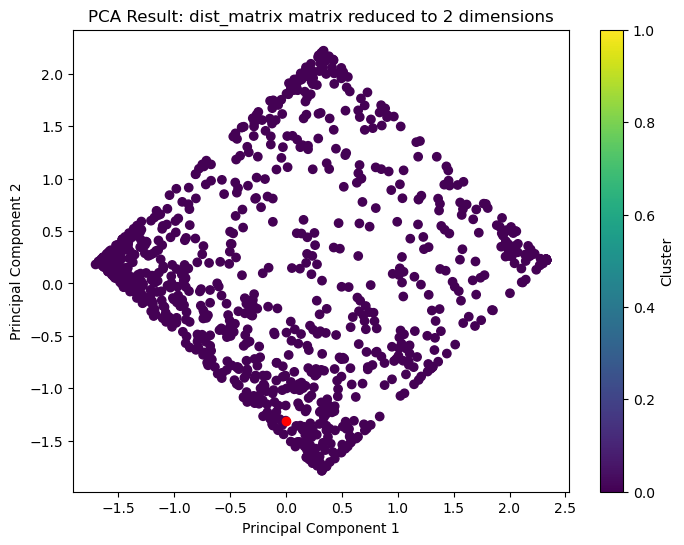

In [18]:
Aggreg_Time_clust=McfC.cluster(Aggreg_Patients,DDA_Clust,ouput,mlflow,Time_Clust_parameters )

#### PREPARATION CLUSTERING DE PARCOURS - CREATION DE COURBES CARACTERISTIQUES DE PARCOURS

In [19]:
# Calcul des distances entre courbes de parcours
dist_matrix=Mcftsc.GetDistanceMatrix(Aggreg_Patients, Aggreg_parameters,Aggprefix)

#EXPORT DE LA MATRICE DE DISTANCE
#dist_matrix.tofile(myouputpath + "Matrice_distance.dat")
np.savetxt(myouputpath + "distance_matrix.csv",dist_matrix,delimiter=",")
mlflow.log_artifact(myouputpath + "distance_matrix.csv", "Matrice de distance inter-Parcours")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Iteration 0/957 - Temps restant estimé: 3.07 minutes
Iteration 100/957 - Temps restant estimé: 2.53 minutes
Iteration 200/957 - Temps restant estimé: 2.10 minutes
Iteration 300/957 - Temps restant estimé: 1.71 minutes
Iteration 400/957 - Temps restant estimé: 1.36 minutes
Iteration 500/957 - Temps restant estimé: 1.04 minutes
Iteration 600/957 - Temps restant estimé: 0.75 minutes
Iteration 700/957 - Temps restant estimé: 0.50 minutes
Iteration 800/957 - Temps restant estimé: 0.28 minutes
Iteration 900/957 - Temps restant estimé: 0.09 minutes
Durée totale de traitement: 88.67 secondes


#### CLUSTERING DES FONCTIONS DE PARCOURS


In [20]:
#CLUST PARCOURS CLUSTERING - MLFLOW CONFIG

#DIMENSION NAME
clust_prefix = "Cl_Parcours"
clust_suffix = "1"
clust_name = clust_prefix + clust_suffix
image_format = ".png"

#Filename
mypath= myouputpath
curve_filename= mypath + clust_name + "_curve" + image_format
curve_mlflowname= clust_name +"_curve"

PCA_filename = mypath + clust_name + "_PCA" + image_format
PCA_mlflowname= clust_name + "_PCA"

Cluster_summary_filename = mypath + clust_name + "_Clust_Summary.csv"
Cluster_summary_mlflowname = clust_name + "_Clust_Summary"

NIP_Carac_filename = mypath + clust_name + "_NIP_Carac.csv"
NIP_Carac_mlflowname = clust_name + "_NIP_Carac"

#mlflowoutput
Parcours_Clust_parameters={
    'Method': "KMeans",
    'Nb_clusters' : default_n_clust,
    'max_nb_clusters' : default_max_clusters,
    'threshold': default_threshold,
    'clust_name' : clust_name,
    'curve_filename' : curve_filename ,
    'curve_mlflowname' : curve_mlflowname, 
    'PCA_filename' : PCA_filename , 
    'PCA_mlflowname' : PCA_mlflowname,
    'Summary_filename' : Cluster_summary_filename,
    'Summary_mlflowname' : Cluster_summary_mlflowname,
    'NIP_Carac_filename' : NIP_Carac_filename,
    'NIP_Carac_mlflowname' : NIP_Carac_mlflowname
    }

#Show output
ouput=False

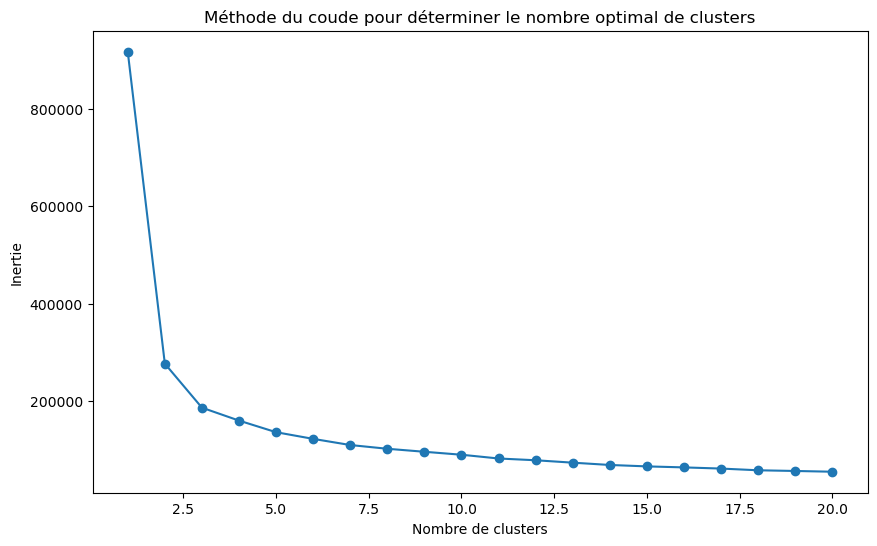

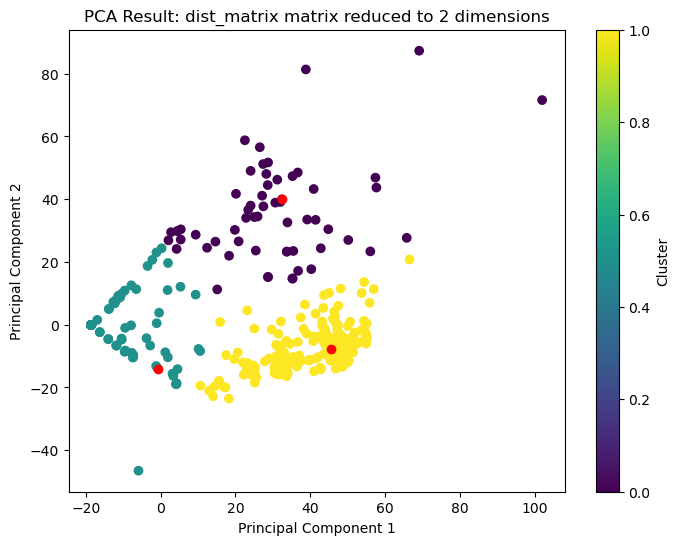

In [21]:
Aggreg_Parcours_clust=McfC.cluster(Aggreg_Patients,dist_matrix,ouput,mlflow,Parcours_Clust_parameters )

#### PLOT CLUSTERS PARCOURS CURVE

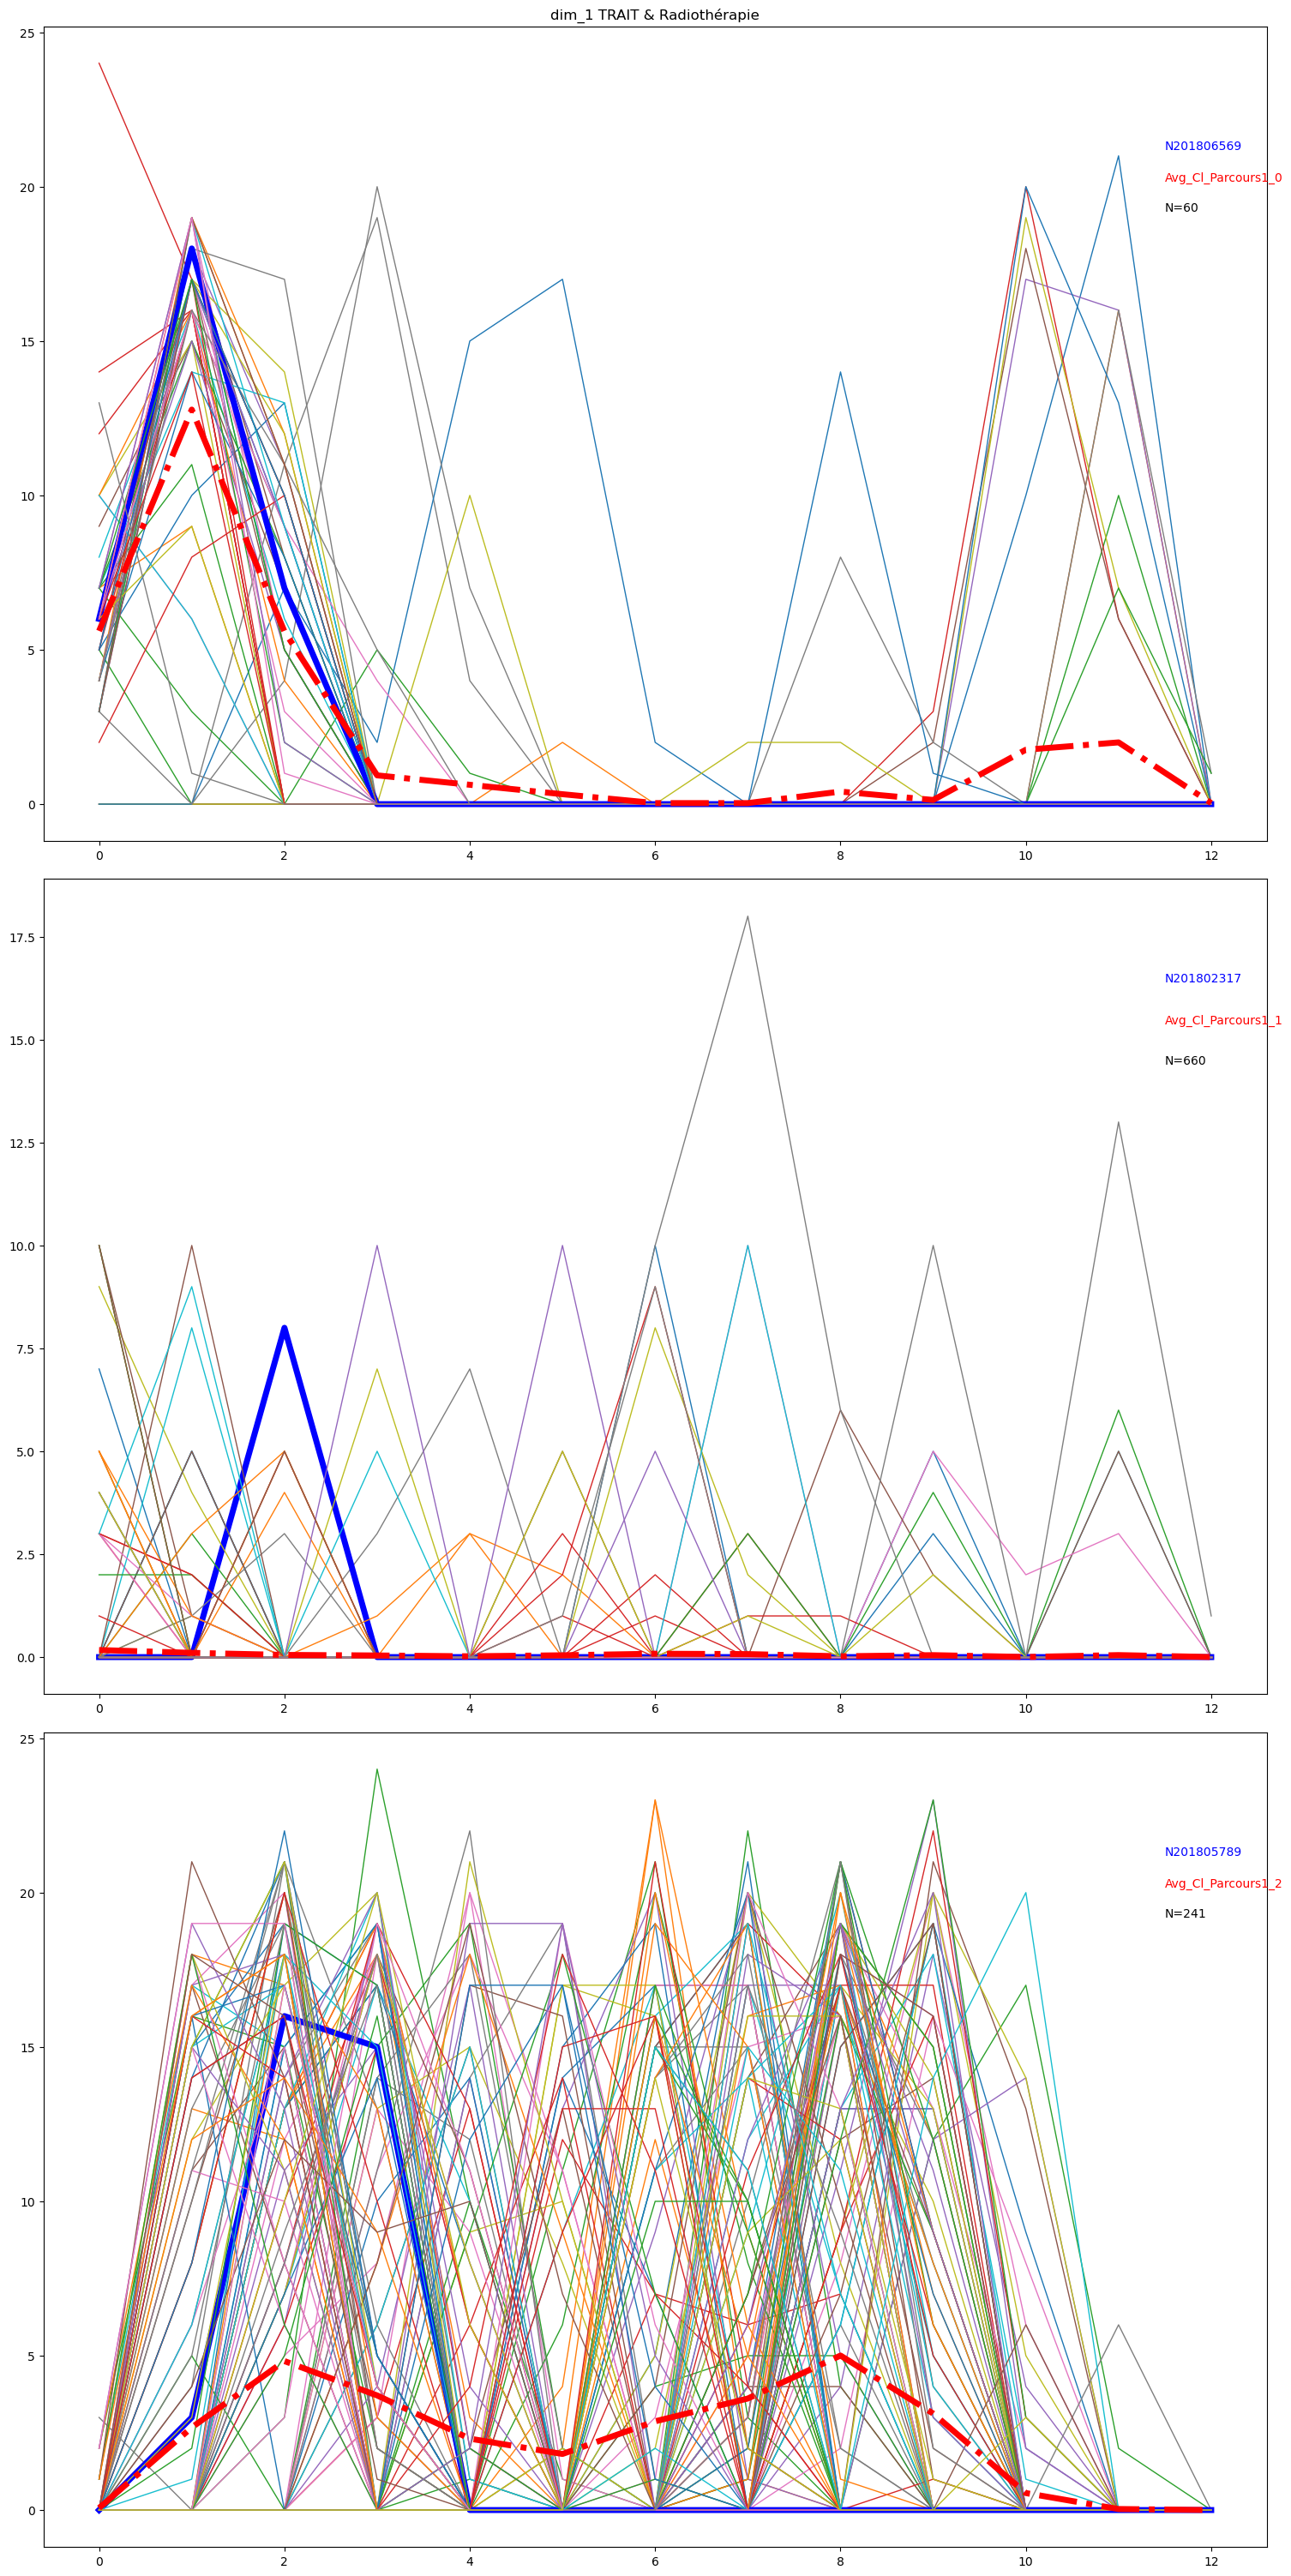

In [22]:
import importlib
importlib.reload(Mcftsc)

Timesteps=int(Aggreg_parameters[Aggprefix + 'Stop_at_item'])-int(Aggreg_parameters[Aggprefix + 'Start_at_item'])
clust_name=Parcours_Clust_parameters['clust_name']

Parcours_nb_clusters={
    'nb_cluster' : Aggreg_Parcours_clust['Nb_clusters'],
    'Column_name' : Parcours_Clust_parameters['clust_name'],
}

Time_nb_clusters={
    'nb_cluster' : Aggreg_Time_clust['Nb_clusters'],
    'Column_name' : Time_Clust_parameters['clust_name'],
}

Mcftsc.plot_TS_clusters(Aggreg_Parcours_clust,Timesteps,myouputpath+ 'TS_curves.png',Parcours_nb_clusters)
mlflow.log_artifact(myouputpath+ 'TS_curves.png', "TS_Curves_Clustering")

#### PLOT LE CLUSTERING DE PARCOURS

ORDER THE CAREPATHES BY TIME
UNE ALTERNATIVE SERAIT DE PRENDRE LE PARCOURS MOYEN DU CLUSTER ET DE CLASSER PAR DISTANCE D'ECART AU PARCOURS MOYEN.

In [23]:
#PREPARE THE DATASET TO BE PLOTED
Parcours_DF=Mcfcp.Prepare_Plot_carepath_clustered_2levels(df_Actes_graph,Aggreg_Parcours_clust,Parcours_Clust_parameters,Aggreg_Time_clust,Time_Clust_parameters, 'Max_J_V1')
Abcisses_DF, Plot_dict =Mcfcp.Compute_abcisses(Parcours_DF,Parcours_Clust_parameters,Time_Clust_parameters)


#SAVE THE CLUSTERING + PLOTTING VALUES TO THE DATABASE
Mcfcp.Save_Cluster_and_Carepath_to_Database(Abcisses_DF,Parcours_Clust_parameters,Time_Clust_parameters,myouputpath)

2023-12-18 18:07:53,267 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-18 18:07:53,267 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_NIP_Cluster
2023-12-18 18:07:53,268 INFO sqlalchemy.engine.Engine [generated in 0.00046s] ()
2023-12-18 18:07:53,279 INFO sqlalchemy.engine.Engine COMMIT
2023-12-18 18:07:53,284 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2023-12-18 18:07:53,285 INFO sqlalchemy.engine.Engine [generated in 0.00053s] ('Tmp_NIP_Cluster', 'dbo')
2023-12-18 18:07:53,291 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-18 18:07:53,291 INFO sqlalchemy.engine.Engine 
CREATE TABLE [Tmp_NIP_Cluster] (
	[index] BIGINT NULL, 
	[NIP] VARCHAR(max) NULL, 
	[Cl_Parcours1] FLOAT(53) NULL,

In [24]:
#Recuperer une table acte avec les clusters
Requete="""SELECT Table_Acte.[NIP]
	  ,Table_Cluster.CL_T1 as Clust
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
  ORDER BY Clust asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]
"""
# AND Table_Acte.[Phase]='Traitement'

df_Actes_graph2=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

filtered_df = df_Actes_graph2[df_Actes_graph2['Phase'] == 'Traitement']
nip_no_treatment_info = df_Actes_graph2[~df_Actes_graph2['NIP'].isin(filtered_df['NIP'])]
nip_no_treatment_info = nip_no_treatment_info[['NIP', 'Clust', 'X_abscisse']].drop_duplicates()
final_df = pd.concat([filtered_df, nip_no_treatment_info], ignore_index=True)
final_df_sorted = final_df.sort_values(by='X_abscisse')

2023-12-18 18:07:53,542 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  ,Table_Cluster.CL_T1 as Clust
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
  ORDER BY Clust asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]

2023-12-18 18:07:53,543 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


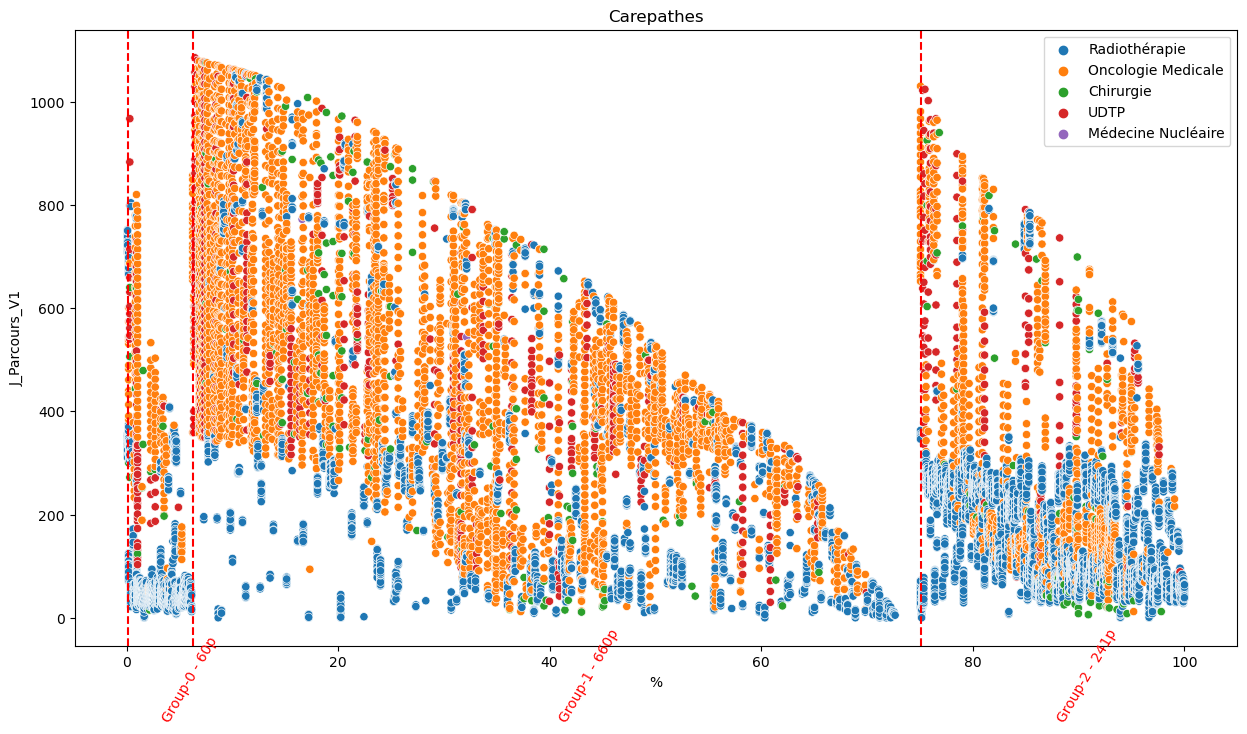

<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\Parcours\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [35]:
import importlib
importlib.reload(Mcfcp)
Mcfcp.plot_df_actes(final_df_sorted,Aggreg_Parcours_clust,Parcours_Clust_parameters,Aggreg_Time_clust,Time_Clust_parameters, Plot_dict, mlflow, myouputpath)

## INTERSECTION DE TOUTES LES AGGREGATIONS ET CLUSTERING

In [ ]:
# ADD HERE THE RESULT PLOT OF THE INTERSECTION OF ALL CLUSTERING DIMENSIONS.

## FIN DU PROGRAMME

In [ ]:
# CLOSE THE MLFLOW
mlflow.end_run()